# Experiment 1: Synthetic data
This notebook compares the accuracy and the wall clock time for various GP ensemble methods

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import guepard
import matplotlib.pyplot as plt
import scipy
import time

from guepard.utilities import get_gpr_submodels
from guepard.baselines import EnsembleMethods, WeightingMethods

rng = np.random.RandomState(123)
tf.random.set_seed(42)

d = 5                   # input space dimension
n = 2**4 * 4**d         # number of observation points
p = 4**d                # number of submodels

print(f"n = {n}, d = {d}, p = {p}")

kernel = gpflow.kernels.Matern52(lengthscales=[1.]*d)
noise_var = 1e-2

lik = gpflow.likelihoods.Gaussian()
lik.variance.assign(noise_var)

mean_function = gpflow.mean_functions.Zero()

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"));


/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


n = 16384, d = 5, p = 1024


/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


We generate samples from the prior distribution as test function.


time for generating data:  48.58598613739014


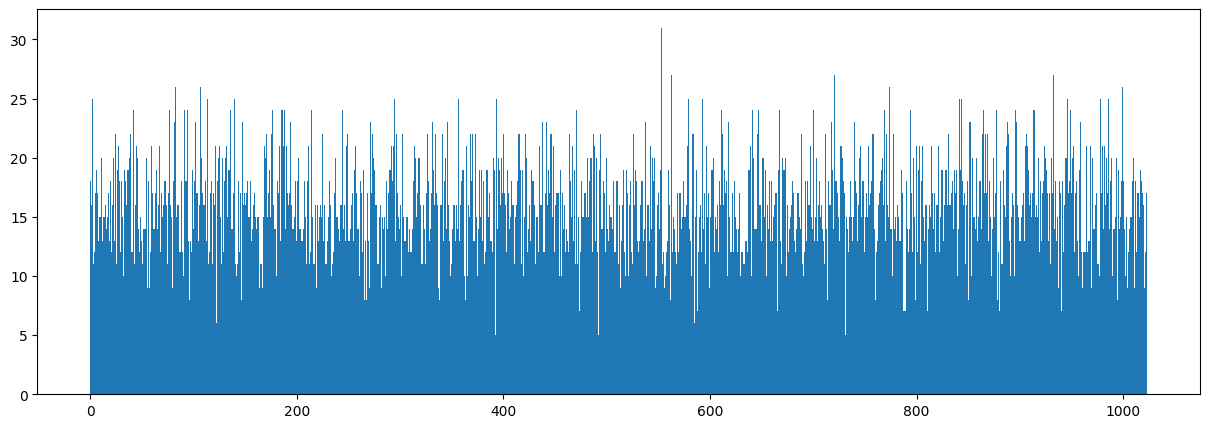

In [2]:
def make_data(n_train, n_test, d):

    n = n_train + n_test
    X = np.random.uniform(size=(n, d))
    Y = np.empty((n, 1))

    dummy_data = np.array([[100.]]*d).T, np.array([[0.]])
    F = gpflow.models.GPR(dummy_data, kernel).predict_f_samples(X, 1).numpy()[0]
    Y = F + np.random.normal(0, np.sqrt(noise_var), size=F.shape)
    return X[:n_train, :], Y[:n_train, :], X[n_train:, :], Y[n_train:, :]

def get_subgroup(X):
    d = X.shape[1]
    z = np.linspace(1/8, 7/8, 4)
    Z = np.meshgrid(*([z]*d))
    Z = np.array([z.flatten() for z in Z]).T

    D2 = np.sum((X[:, None, :] - Z[None, :, :])**2, axis=-1)

    ind = np.argmin(D2, axis=1)
    return(ind)

start_time = time.time()
X, Y, Xtest, Ytest = make_data(n, 100, d)
ind = get_subgroup(X)
wct = time.time() - start_time
print("time for generating data: ", wct)

plt.figure(figsize=(15, 5))
plt.hist(ind, bins=p);



In [3]:
num_rep = 5
list_method = [EnsembleMethods.BARY, EnsembleMethods.GPOE, EnsembleMethods.RBCM]
list_weight = [WeightingMethods.VAR, WeightingMethods.VAR, WeightingMethods.ENT]

method_name = [met.value for met in EnsembleMethods] + [m.value + w.value for m, w in zip(list_method, list_weight)] + ["Equiv. Obs.", "NestedGP"]
num_models = len(method_name)

NLPD = np.zeros((num_rep, num_models))
TIME = np.zeros((num_rep, num_models)) 
for i in range(num_rep):
    # Generate data
    print(f'------------ iteration {i} ------------')
    start_time = time.time()
    X, Y, Xtest, Ytest = make_data(n, 100, d)
    ind = get_subgroup(X)
    datasets = [(X[ind==i, :], Y[ind==i, :]) for i in range(p)]
    wct = time.time() - start_time
    print("time for generating data: ", wct)

    # get submodels
    submodels = get_gpr_submodels(datasets, kernel, mean_function=mean_function, noise_variance=noise_var)

    # NLPD and timing for PoE, GPoe, BCM, rBCM, BAR
    for j, method in enumerate(EnsembleMethods):
        start_time = time.time()
        m = guepard.Ensemble(submodels, method, WeightingMethods.NONE)
        NLPD[i, j] = -np.mean(m.predict_log_density((Xtest, Ytest)))
        TIME[i, j] = time.time() - start_time

    for method, weight in zip(list_method, list_weight):
        j += 1
        start_time = time.time()
        m = guepard.Ensemble(submodels, method, weight)
        NLPD[i, j] = -np.mean(m.predict_log_density((Xtest, Ytest)))
        TIME[i, j] = time.time() - start_time

    start_time = time.time()
    m = guepard.EquivalentObsEnsemble(submodels)
    NLPD[i, j+1] = -np.mean(m.predict_log_density((Xtest, Ytest)))
    TIME[i, j+1] = time.time() - start_time 

    start_time = time.time()
    m = guepard.NestedGP(submodels)
    NLPD[i, j+2] = -np.mean(m.predict_log_density((Xtest, Ytest)))
    TIME[i, j+2] = time.time() - start_time 

    print('time: ', np.round(TIME[i, :], 2))
    print('nlpd: ', np.round(NLPD[i, :], 2))
        
np.savez(f"exp1:d_{d}-n_{n}-p_{p}.npz", TIME=TIME, NLPD=NLPD, method_name=method_name)

------------ iteration 0 ------------
time for generating data:  47.91416001319885
Instructions for updating:
Do not call `graph_parents`.
time:  [  5.34   5.36   5.37   5.43   5.38   5.65   5.43   5.39   6.49 274.5 ]
nlpd:  [ 1.1   0.35  1.1  -0.2   0.61  0.2  -0.22 -0.72 -0.69 -0.81]
------------ iteration 1 ------------
time for generating data:  47.801939964294434
time:  [  5.35   5.41   5.65   5.41   5.39   5.34   5.33   5.32   6.37 274.05]
nlpd:  [ 4.67  0.46  4.67  1.66  0.77  0.33 -0.14  0.02 -0.68 -0.47]
------------ iteration 2 ------------
time for generating data:  47.807162284851074
time:  [  5.38   5.4    5.33   5.37   5.46   5.38   5.36   5.36   6.58 277.35]
nlpd:  [ 3.89  0.42  3.89  1.92  0.71  0.3  -0.15  0.14 -0.62 -0.62]
------------ iteration 3 ------------
time for generating data:  48.150084018707275
time:  [  5.49   5.51   5.53   5.36   5.49   5.65   5.77   5.73   6.59 273.17]
nlpd:  [ 4.55  0.47  4.55  1.76  0.8   0.32 -0.13  0.01 -0.41 -0.52]
------------ iter

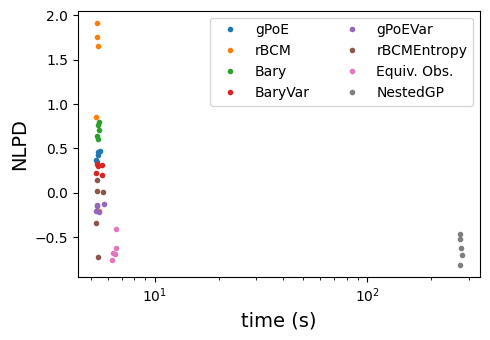

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
#plt.gca().set_prop_cycle(marker=['.', '<', '>', '*', 'o', 'X', '^', 'v']) # gca()=current axis

j = -1
for i in range(num_models):
    if i not in [0, 2]:
        j += 1
        #plt.plot(TIME[:, i], NLPD[:, i], linestyle="", color=f"C{j}", label=method_name[i])
        plt.plot(TIME[:, i], NLPD[:, i], f"C{j}.", label=method_name[i])


plt.legend(ncol=2)
plt.xlabel('time (s)', fontsize=14)
plt.ylabel('NLPD', fontsize=14)
plt.semilogx()
plt.tight_layout()
plt.savefig(f"exp1:d_{d}-n_{n}-p_{p}.pdf")

Text(0.5, 1.0, 'd = 5, n = 16384, p = 1024')

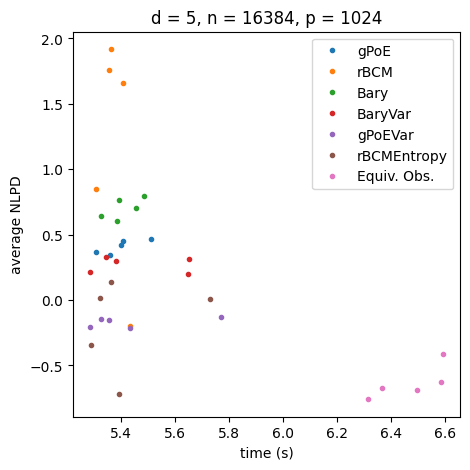

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in range(num_models):
    if i not in [0, 2, num_models-1]:
        plt.plot(TIME[:, i], NLPD[:, i], ".", label=method_name[i])

plt.legend()
plt.xlabel('time (s)')
plt.ylabel('average NLPD')
plt.title(f'd = {d}, n = {n}, p = {p}')


In [6]:
2**14
2**10

1024

In [7]:
np.savez(f"exp1:d_{d}-n_{n}-p_{p}.npz", TIME=TIME, NLPD=NLPD, method_name=method_name)